In [7]:
import ee
import rasterio
import numpy as np
from pprint import pprint
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import colors

In [8]:
from channel_classifier.internal.ee_utils import add_labels, add_cloud_score, add_cloud_label, compute_error_image, download_tiff, get_landsat_image, get_landsat_composite, remap_modis_labels
from channel_classifier.internal.settings import TRAINING_BANDS, MODIS_KEEP_VALUES, JRC_VALUES

In [9]:
from skimage.morphology import binary_dilation, binary_erosion, disk

In [10]:
CLOUD_THRESH = 20.0
MODIS_LABELS = ['']

In [6]:
modis_proj = ee.Image('MODIS/006/MCD12Q1/2012_01_01').projection().getInfo()
water_proj = ee.Image('JRC/GSW1_0/MonthlyHistory/2012_01').projection().getInfo()
landsat_img = ee.Image(ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA').first())
print(modis_proj['crs'])
print(modis_proj['transform'])
print(water_proj['crs'])
print(water_proj['transform'])

SR-ORG:6974
[463.312716528, 0.0, -20015109.354, 0.0, -463.312716527, 10007554.677]
EPSG:4326
[0.00026949458523585647, 0.0, -180.00001488697754, 0.0, -0.00026949458523585647, 78.00008729939917]


In [11]:
ee.Initialize()

In [12]:
path, row = [7, 65] # Ucayali
#path, row = [74, 16] # Alaska
#path, row = [3, 69] # RMDD
year, month, day = [2014, 9, 7]
image = get_landsat_image(path, row, year, month, day)
TRAINING_BANDS = image.bandNames().getInfo()
TRAINING_BANDS.remove('BQA')
image = add_cloud_score(image)
stacked = add_labels(image, year, month)
labels = remap_modis_labels(stacked)
bands = stacked.bandNames().getInfo()
bands.remove('label')
print(bands)
stacked = stacked.select(bands)
print(stacked.bandNames().getInfo())
stacked = stacked.addBands(labels, ['label'])
stacked = add_cloud_label(stacked, 50)
#stacked = stacked.select(TRAINING_BANDS)
#stacked = mask_channels(stacked)
proj = stacked.select(['B1']).projection()
scale = stacked.select(['B1']).projection().nominalScale()
print(stacked.bandNames().getInfo())

[u'B1', u'B2', u'B3', u'B4', u'B5', u'B6', u'B7', u'B8', u'B9', u'B10', u'B11', u'BQA', u'cloud']
[u'B1', u'B2', u'B3', u'B4', u'B5', u'B6', u'B7', u'B8', u'B9', u'B10', u'B11', u'BQA', u'cloud']
[u'B1', u'B2', u'B3', u'B4', u'B5', u'B6', u'B7', u'B8', u'B9', u'B10', u'B11', u'BQA', u'cloud', u'label']


In [ ]:
filename = download_tiff(image.select(['cloud']).clip(image.geometry()), scale=200)
with rasterio.open(filename) as r:
    clouds = r.read(1)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(clouds > 50, cmap='Reds', vmin=0, vmax=1)
plt.colorbar(im, ax=ax, label='Cloud score', shrink=0.5)

In [ ]:
print(image.bandNames().getInfo())
filename = download_tiff(image.clip(image.geometry()), scale=240)
with rasterio.open(filename) as r:
    im = r.read()
rgb = np.stack([im[3], im[2], im[1]], axis=-1)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(rgb)

(1.0, 8.0)


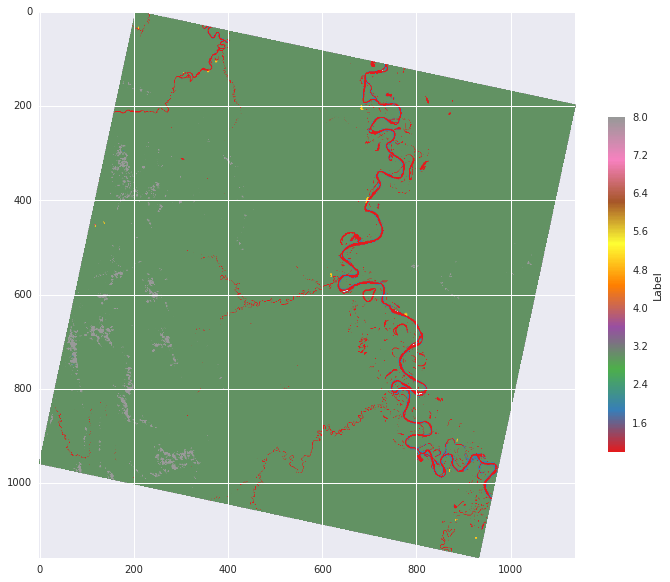

In [13]:
filename = download_tiff(stacked.clip(image.geometry()), scale=200)
with rasterio.open(filename) as r:
    labels = r.read(r.count).astype(float)
    #labels[labels == 12] = 2
    labels[labels == 0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(labels, cmap='Set1', vmin=1, vmax=8)
plt.colorbar(im, ax=ax, label='Label', shrink=0.5)
print(np.nanmin(labels), np.nanmax(labels))

In [ ]:
training = stacked.sample(numPixels=1000, projection=proj, scale=1, seed=2).filter(ee.Filter.neq('label', 0))
validation = stacked.sample(numPixels=10000, projection=proj, scale=1, seed=1).filter(ee.Filter.neq('label', 0))

In [ ]:
clf = ee.Classifier.randomForest(10)
print(clf.mode().getInfo())
clf = clf.setOutputMode('PROBABILITY')
print(clf.mode().getInfo())
classifier = clf.train(training, 'label')

In [ ]:
classified = stacked.classify(classifier, 'classification')
print(classified.bandNames().getInfo())

In [ ]:
validated = validation.classify(classifier, 'classification')
accuracy = validated.errorMatrix('label', 'classification')
print(accuracy.accuracy().getInfo())

In [ ]:
error = compute_error_image(stacked.select(['label']), classified.clip(image.geometry()), 1)

In [ ]:
filename = download_tiff(error, scale=240)
with rasterio.open(filename) as r:
    err = r.read(1)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(err, cmap='RdBu_r', vmin=-1, vmax=1) #, cmap=cmap, norm=norm)
cb = plt.colorbar(im, ax=ax, shrink=0.5, ticks=[-1, 0, 1])
cb.ax.set_yticklabels(['Omission', '', 'Comission']);

In [ ]:
filename = download_tiff(classified.select(['classification']), scale=200)

In [ ]:
filename = download_tiff(classified.select(['classification']).clip(image.geometry()), scale=200)
with rasterio.open(filename) as r:
    labels = r.read(1).astype(float)
    #labels[labels == 12] = 2
    #labels[labels == 0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(labels, cmap='viridis', vmin=0)
plt.colorbar(im, ax=ax, label='Label probability', shrink=0.5)